# IQ Multi Target Detection In Heavy Tailed Clutter Using Diffusion

## Imports

In [2]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### wandb

In [3]:
# os.environ["#wandb_NOTEBOOK_NAME"] = "compare.ipynb"
# #wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
# #wandb.init(project="Diffusion-for-radar", mode="online")

## dataset

### Actual dataset

In [4]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        """
        Creates the raw (unscaled) target signals for each target,
        then (if old scnr approach) scales them to achieve the desired scnr in dB,
        or returns them raw for later scaling if snr/cnr approach is used.
        """
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        
        # If we are using the old SCNR approach, scale immediately
        # Gains in dB => each target’s SCNR
        if (self.snr_dB is None) or (self.cnr_dB is None):
            # Old approach: sum all scaled targets into a single matrix
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            # With the new approach, we do NOT scale by SCNR here.
            # We return the raw sum across all targets, for later power-based scaling.
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        # M is the covariance-like matrix for correlated clutter
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        # Draw complex Gaussian
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        # Impart heavy–tailed behavior via Gamma modulation (shape = scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation
        # using a range–steering operation.
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        """
        Generate one radar data frame, label map, and the separate S, C, W
        so that we can control SNR and CNR (if specified).
        """
        # 1. Generate unscaled noise (mean 0, unit variance in each real/imag component).
        #    We'll measure it and scale later if snr/cnr is used.
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        # 2. Generate unscaled clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        
        # 3. Prepare to generate target signal(s)
        #    We'll choose random targets if with_targets == True
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            # If new SNR/CNR approach is NOT used, we fallback to scnr or [-5, 10] dB random
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                # Just pass dummy dB array here; we won't scale inside 'generate_target_signal'
                # Instead, we will do the scaling outside
                S_raw = []
                for i in range(n):
                    # Each target can have the same 'gain' placeholder
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                # Sum all targets
                S_unscaled = sum(S_raw)

            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        # ---------------------------
        # NEW: If snr & cnr are given, do amplitude scaling here
        # ---------------------------
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            # 1) measure raw powers
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            # 2) define desired linear ratios
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            # 3) define desired final powers
            #    We'll anchor the noise to "1.0" average power for convenience
            #    (or you could anchor it to some other power). Then scale clutter & signal.
            #    Step (A): Scale noise to final_noise_power = 1.0
            #             => alpha_n = sqrt(1 / noise_power).
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            #    Step (B): Clutter should have average power = cnr_lin * final_noise_power
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            #    Step (C): Signal should have average power = snr_lin * final_noise_power
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        """
        Return the data and label for sample 'idx'.
        """
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB

### Visualization

##### functions

In [23]:
def visualize_sample(dataset, sample_index: int = 0):

    signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[sample_index]
    print(scnr_dB)
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 6, 1)
    plt.imshow(torch.real(signal), aspect='auto', cmap='viridis')
    plt.title("Real clean Signal", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 2)
    plt.imshow(torch.imag(signal), aspect='auto', cmap='viridis')
    plt.title("Imaginary clean Siganl", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 3)
    plt.imshow(torch.real(clutter), aspect='auto', cmap='viridis')
    plt.title("Real Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 4)
    plt.imshow(torch.imag(clutter), aspect='auto', cmap='viridis')
    plt.title("Imaginary Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 5)
    plt.imshow(torch.real(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("real white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 6)
    plt.imshow(torch.imag(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("Imaginary white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.subplot(1,3,1)
    plt.imshow(abs(IQ), aspect='auto', cmap='viridis')
    plt.title("Noisy IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,2)
    plt.imshow(abs(signal), aspect='auto', cmap='viridis')
    plt.title("Clean IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,3)
    plt.imshow(rd_label, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Label", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.tight_layout()
    plt.show()


In [24]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=1,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )
            
            signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[0]

            iq_magnitude = torch.abs(IQ)
            iq_db = 20 * torch.log10(iq_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(iq_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            
            _, C_sample, W_sample, _, _, _ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


##### view

tensor(-9.8831)


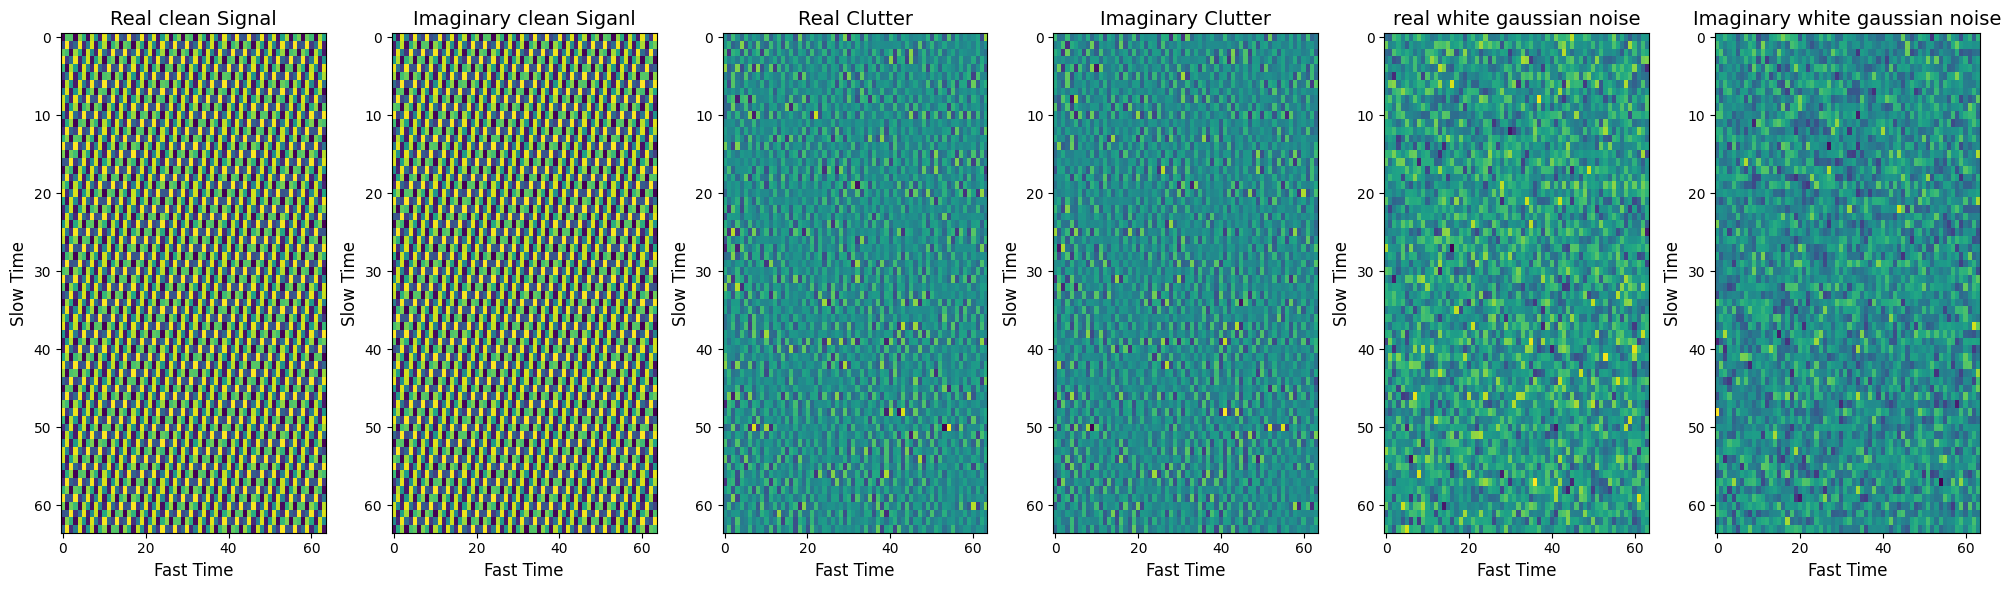

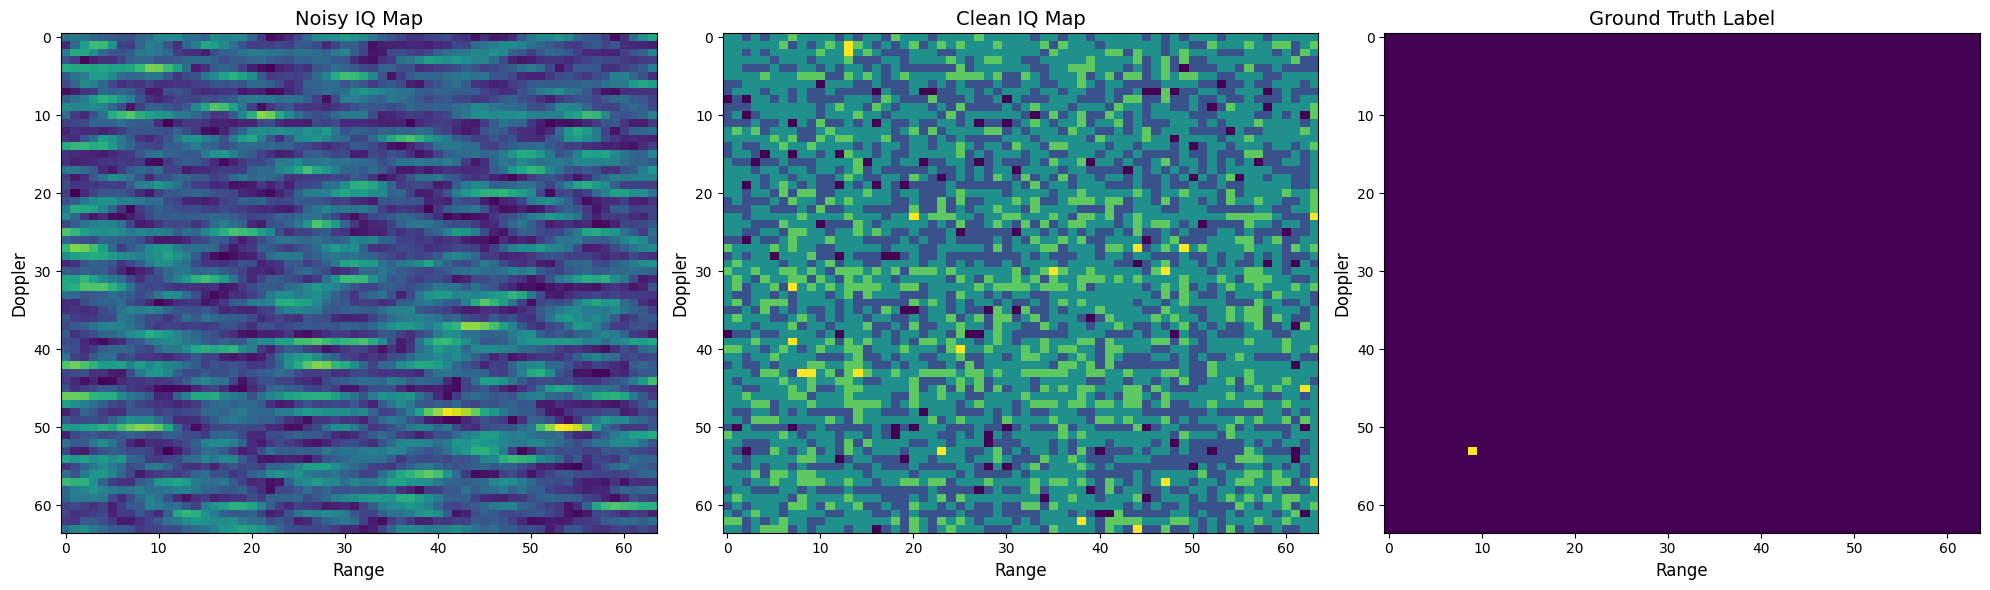

In [25]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, scnr=-10)
visualize_sample(train_dataset_with_targets, sample_index=1)

tensor(14.8648)


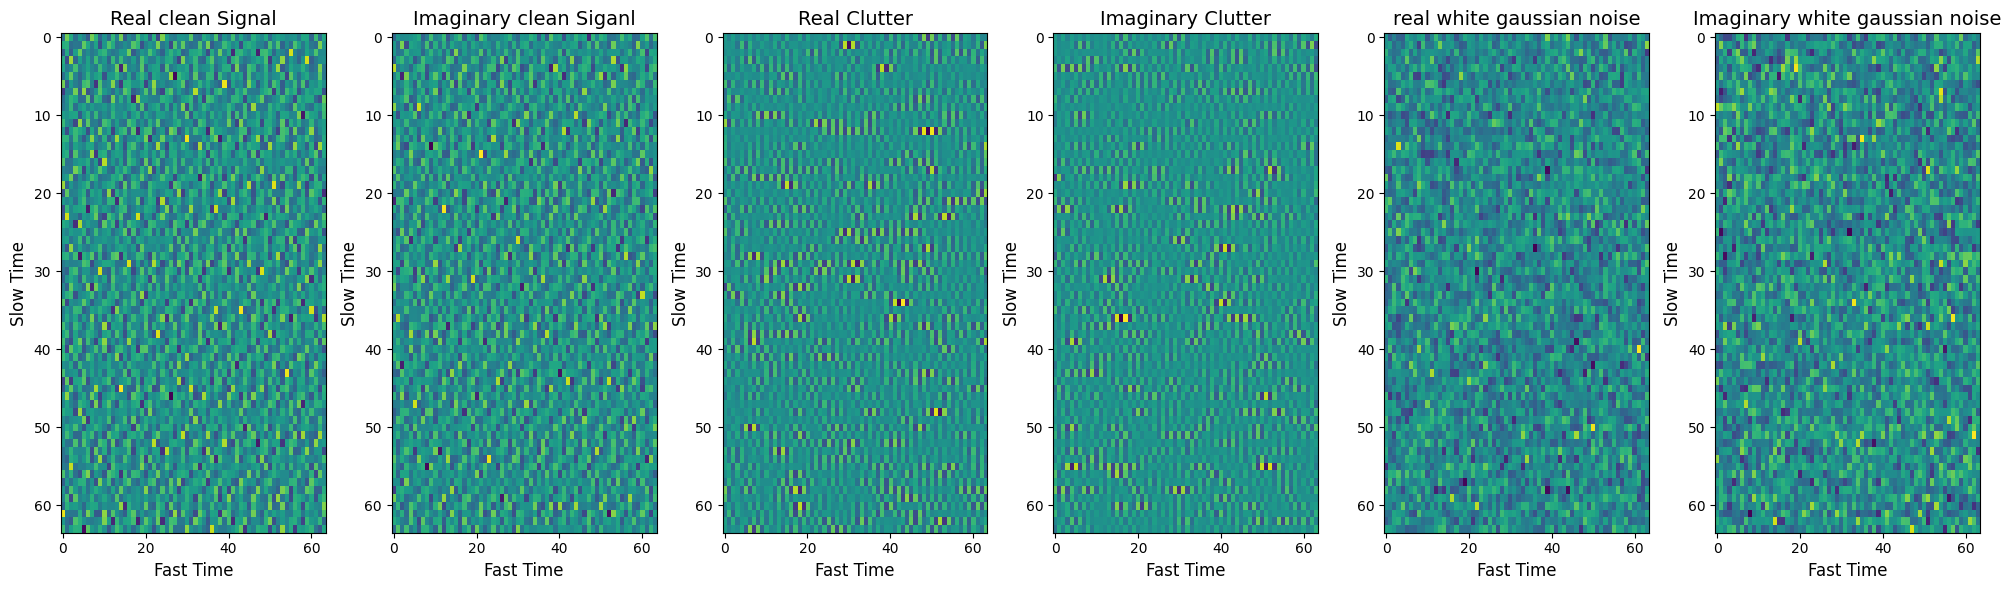

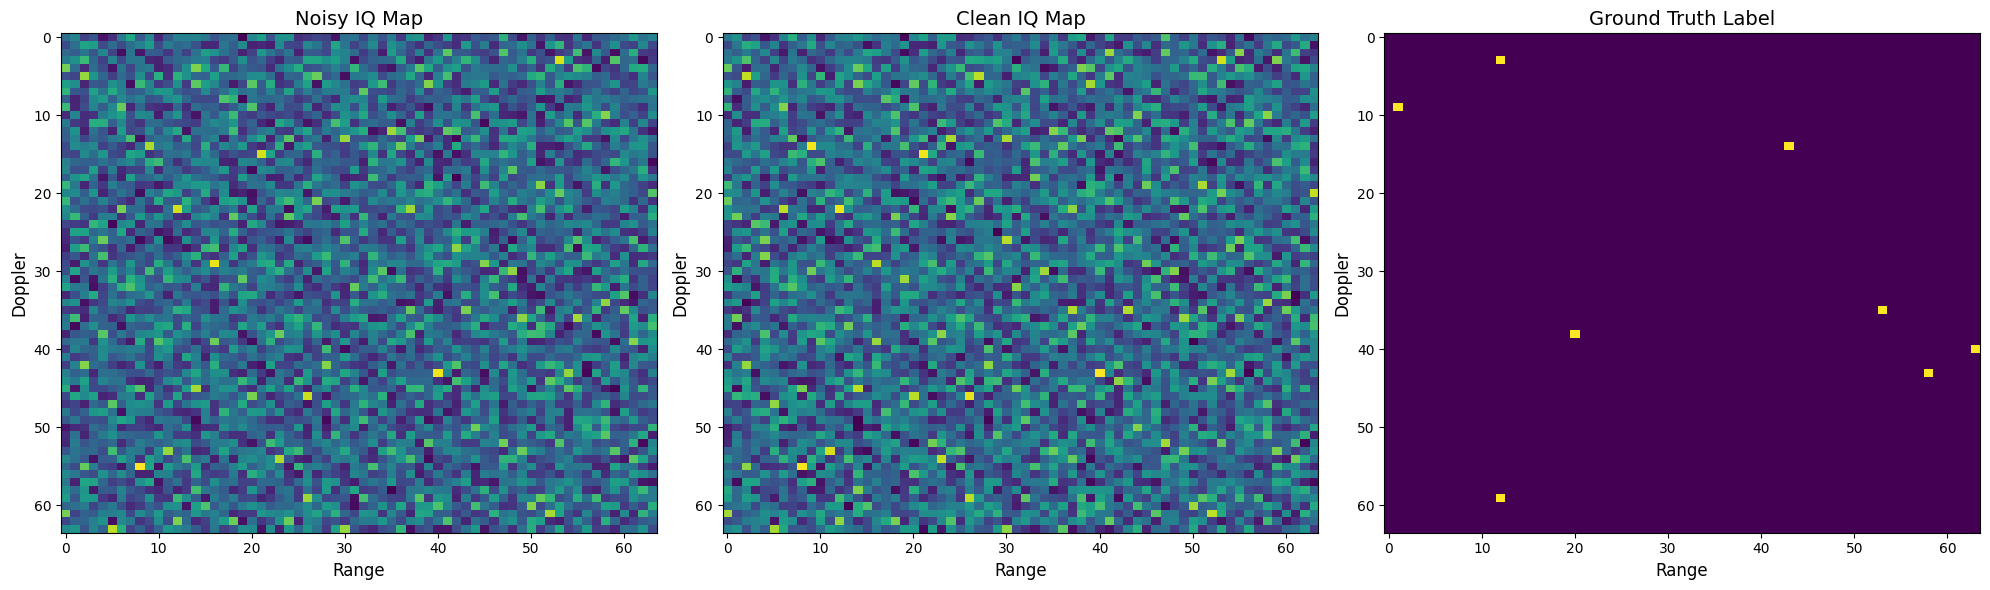

In [143]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, snr=30, cnr=15)
visualize_sample(train_dataset_with_targets, sample_index=1)

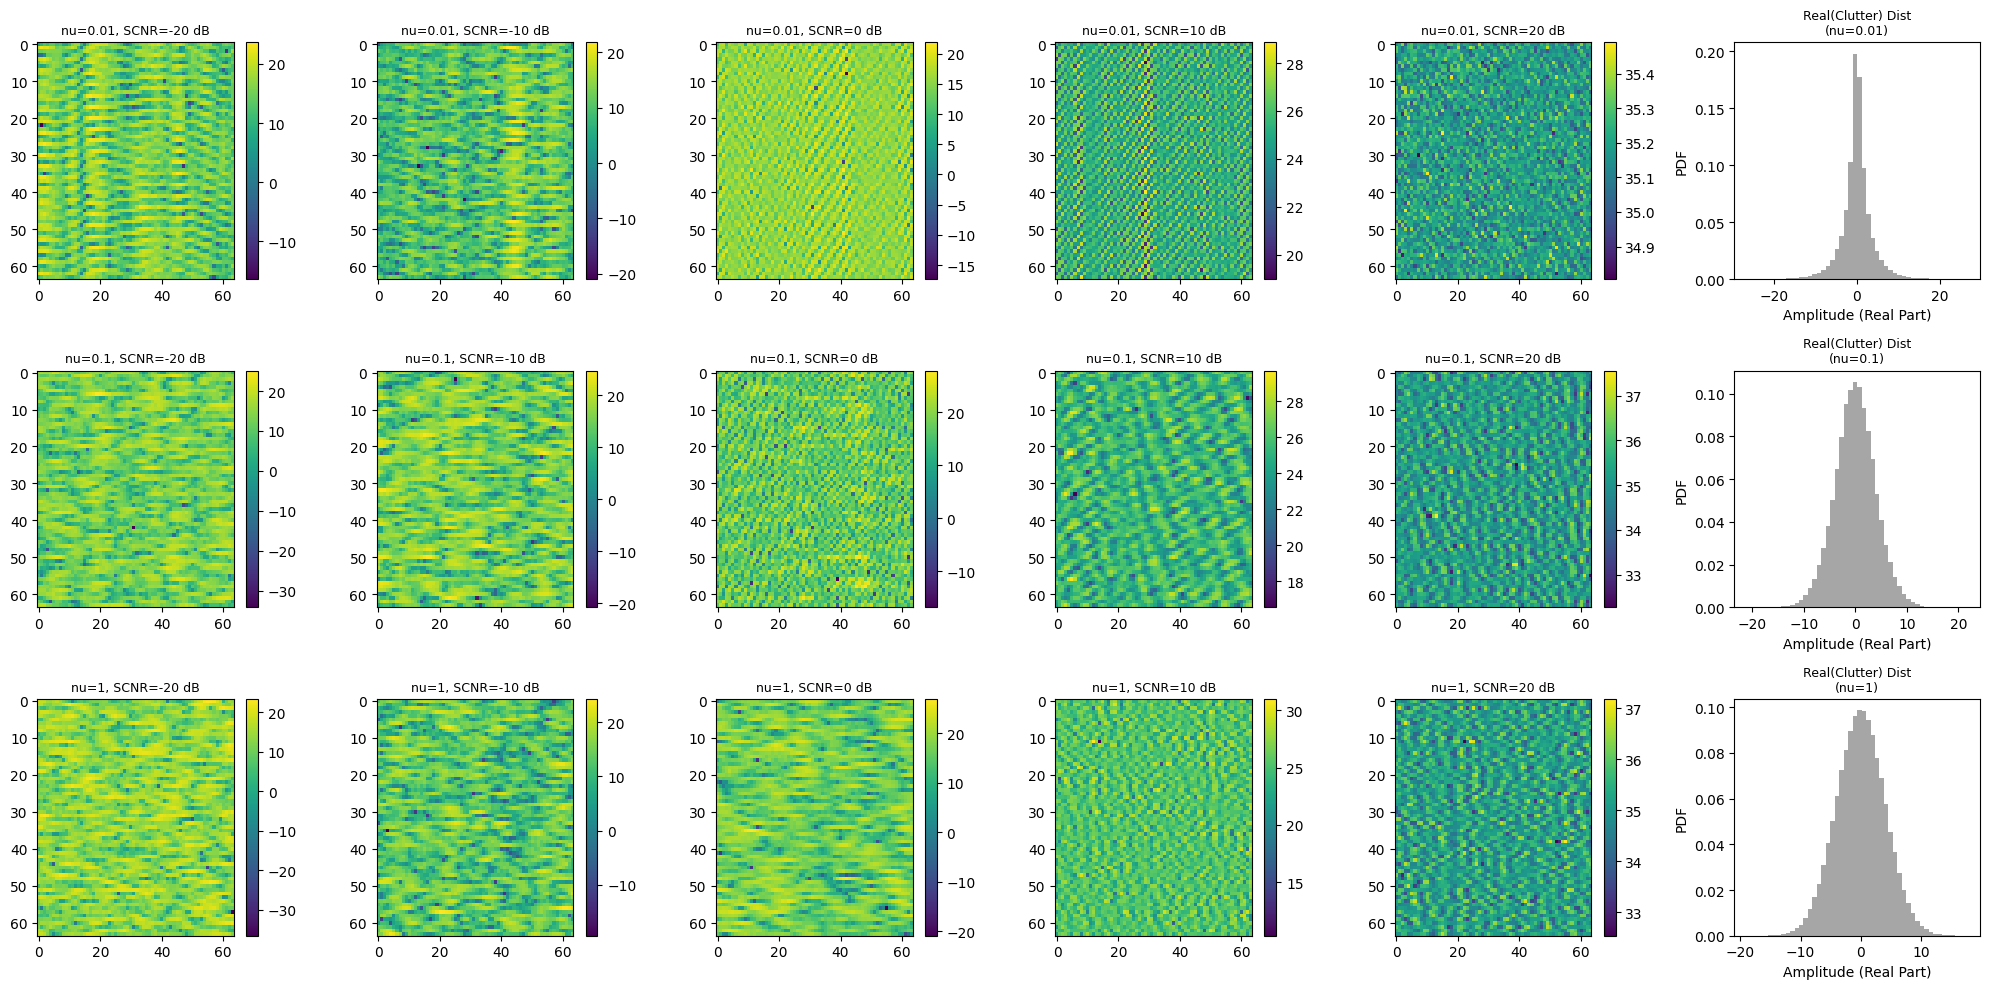

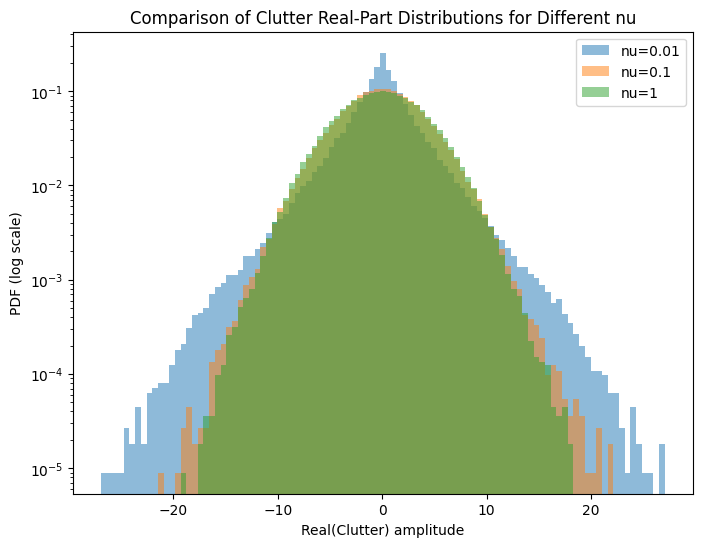

In [41]:
compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset)

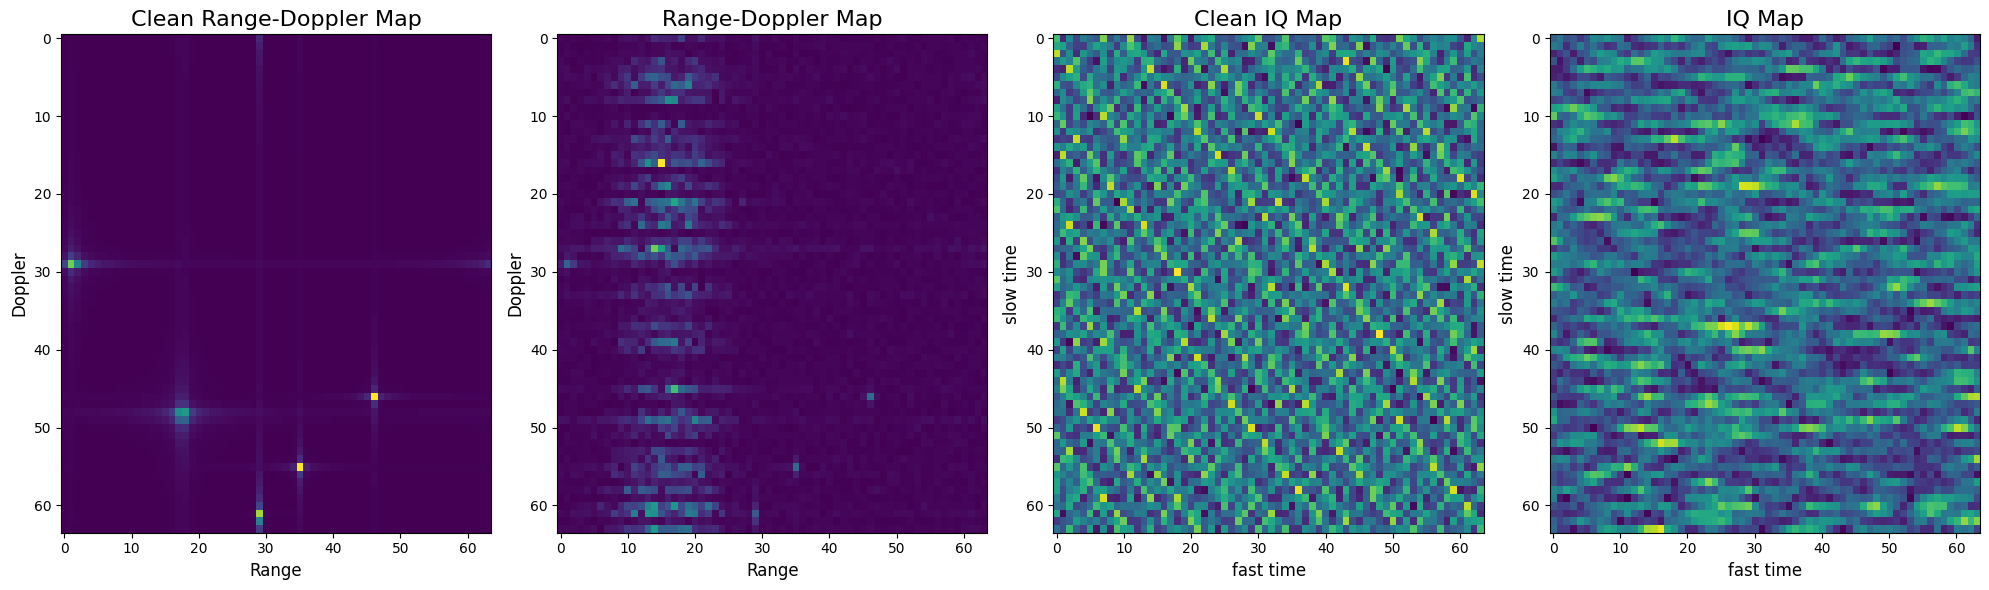

In [164]:
def fft_range_doppler(IQ_map):
    RD_map = torch.fft.fftshift(torch.fft.fft2(IQ_map, dim=(-2, -1)), dim=(-2, -1))
    return RD_map 
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, snr=0 ,cnr=15)
signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = train_dataset_with_targets[0]
Z =fft_range_doppler(IQ)
Y = fft_range_doppler(signal)


plt.figure(figsize=(20, 6))
plt.subplot(1,4,1)
plt.imshow(abs(Y), aspect='auto', cmap='viridis')
plt.title("Clean Range-Doppler Map", fontsize=16)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1,4,2)
plt.imshow(abs(Z), aspect='auto', cmap='viridis')
plt.title("Range-Doppler Map", fontsize=16)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1,4,3)
plt.imshow(abs(signal), aspect='auto', cmap='viridis')
plt.title("Clean IQ Map", fontsize=16)
plt.xlabel("fast time", fontsize=12)
plt.ylabel("slow time", fontsize=12)

plt.subplot(1,4,4)
plt.imshow(abs(IQ), aspect='auto', cmap='viridis')
plt.title("IQ Map", fontsize=16)
plt.xlabel("fast time", fontsize=12)
plt.ylabel("slow time", fontsize=12)

plt.tight_layout()
plt.show()


# First Research Part

## CFAR functions

In [43]:
def ca_cfar_2d(signal, num_train, num_guard, Pfa):
    """
    Standard CA–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Scaling factor for exponential noise
    alpha = num_training_cells * (Pfa**(-1/num_training_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            noise_level = np.mean(training_cells)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map

def tm_cfar_2d(signal, num_train, num_guard, trim_ratio, Pfa):
    """
    TM–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Number of cells to trim from each end
    trim_cells = int(trim_ratio * num_training_cells)
    effective_cells = num_training_cells - 2 * trim_cells
    if effective_cells <= 0:
        effective_cells = num_training_cells  # fallback
    alpha = effective_cells * (Pfa**(-1/effective_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            sorted_cells = np.sort(training_cells)
            if 2 * trim_cells < num_training_cells:
                trimmed = sorted_cells[trim_cells: num_training_cells - trim_cells]
            else:
                trimmed = sorted_cells
            noise_level = np.mean(trimmed)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map


In [44]:
def simulate_cfar_performance(cfar_func, specified_Pfa, nu_val, num_trials=100,
                              n_targets=3, random_n_targets=False, **cfar_kwargs):
    """
    For a given CFAR function, specified false–alarm parameter, and clutter nu,
    simulate num_trials frames and compute the average probability of detection (Pd)
    and measured probability of false alarm (Pfa_meas).
    """
    dataset = RadarDataset(num_samples=num_trials, n_targets=n_targets,
                           random_n_targets=random_n_targets, nu=nu_val)
    total_true_detections = 0
    total_targets = 0
    total_false_alarms = 0
    total_non_target_cells = 0
    for i in range(num_trials):
        _, _, _, _, RD_map, rd_label = dataset[i]
        RD_mag = torch.abs(RD_map).detach().numpy()
        detection_map = cfar_func(RD_mag, **cfar_kwargs, Pfa=specified_Pfa)
        gt = rd_label.detach().numpy()
        true_detections = np.sum((detection_map == 1) & (gt == 1))
        false_alarms = np.sum((detection_map == 1) & (gt == 0))
        total_targets += np.sum(gt)
        total_true_detections += true_detections
        total_false_alarms += false_alarms
        total_non_target_cells += (gt.size - np.sum(gt))
    pd_rate = total_true_detections / total_targets if total_targets > 0 else 0
    measured_pfa = total_false_alarms / total_non_target_cells if total_non_target_cells > 0 else 0
    return pd_rate, measured_pfa

## DAFC functions

In [45]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

In [46]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        
        if detection_type == "range":
            self.input_dim = (64, 128)  # (K, 2*N)
        else:  # doppler
            self.input_dim = (64, 128)  # (N, 2*K)
    
        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


In [47]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [48]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, rd_label,_ in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [49]:
def plot_training_history(history: dict, detection_type: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


In [50]:
def train_model(model, criterion, train_loader, val_loader, detection_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    for epoch in epoch_pbar:
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for _, _, _, X, rd_label, _ in train_loader:
            X = X.to(device)
            rd_label = rd_label.to(device)

            # Preprocess input and get 1D label
            label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, label)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == label).float().sum().item()
            train_total += label.numel()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for _, _, _, X, rd_label, _  in val_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                outputs = model(X)
                loss = criterion(outputs, label)

                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == label).float().sum().item()
                val_total += label.numel()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        # Update history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_accuracy"].append(epoch_train_acc)
        history["val_accuracy"].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

        # Print epoch results every 10 epochs
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    torch.save(model.state_dict(), f"{detection_type}_64_IQ_model.pt")

    return history


## Evaluation functions

In [56]:
def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA (ROC curves) for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa) tuples.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('ROC Curves for Different Clutter Conditions', fontsize=16, fontweight='bold')

    for nu, (pd, pfa) in results.items():
        plt.plot(pfa, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('Probability of False Alarm (log scale)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range")
    doppler_model = DAFCRadarNet(detection_type="doppler")

    try:
        range_model.load_state_dict(torch.load('/home/hawk/Desktop/models/BGU/DAFC IQ models/range_64_IQ_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('/home/hawk/Desktop/models/BGU/DAFC IQ models/doppler_64_IQ_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model

def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa, scnr) 
        tuples, where pd and pfa are probabilities and scnr is a list 
        of SCNR values.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('Detection Performance vs SCNR', fontsize=16, fontweight='bold')

    for nu, (pd, pfa, scnr) in results.items():
        plt.plot(scnr, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('SCNR (dB)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [149]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for _, _, _, X, Y, _ in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                # if needed
                X = X.to(torch.complex64)  # Convert X to a complex type if not already
                #print(X.shape)
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        ###X_rv_proj = abs(X_rv_proj.to(device))
        ###Y_rv       = Y_rv.to(device)
        ###Y_rv_binary= Y_rv_binary.to(device)

        #print(X_rv_proj.shape, Y_rv.shape, Y_rv_binary.shape)
        ###U = X_rv_proj[:, :, :63] * Y_rv * Y_rv_binary
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range



## Train & Evaluate DAFC

In [65]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0, random_n_targets=False)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

In [59]:
print("\nTraining IQ Range Detector:")
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(range_history, "Range")
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(doppler_history, "Doppler")


Training IQ Range Detector:


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.i

KeyboardInterrupt: 

In [66]:
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)

using device:  cuda
Loaded range model successfully
Loaded doppler model successfully
Running PD vs PFA test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30><function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/pr

Found threshold = 0.1377, PFA = 0.000010 after 10 iterations


Found threshold = 0.1279, PFA = 0.000050 after 10 iterations


Found threshold = 0.0664, PFA = 0.000100 after 8 iterations


Found threshold = 0.0415, PFA = 0.000499 after 11 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:17<00:34, 17.35s/it]

Found threshold = 0.0327, PFA = 0.001003 after 11 iterations


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
Exception ignored in:   File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>self._shutdown_workers()

Traceback (most recent call last):
  Fil

Found threshold = 0.1189, PFA = 0.000010 after 12 iterations


Found threshold = 0.0874, PFA = 0.000050 after 11 iterations


Found threshold = 0.0579, PFA = 0.000100 after 12 iterations


Found threshold = 0.0389, PFA = 0.000501 after 13 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [00:34<00:17, 17.30s/it]

Found threshold = 0.0315, PFA = 0.000996 after 12 iterations


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>

Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Except

Found threshold = 0.1292, PFA = 0.000010 after 12 iterations


Found threshold = 0.0996, PFA = 0.000050 after 9 iterations


Found threshold = 0.0725, PFA = 0.000099 after 12 iterations


Found threshold = 0.0327, PFA = 0.000504 after 11 iterations


Testing clutter conditions: 100%|██████████| 3/3 [00:52<00:00, 17.34s/it]

Found threshold = 0.0278, PFA = 0.000991 after 11 iterations



Running PD vs SCNR test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30><function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'c

Found threshold = 0.0591, PFA = 0.000498 after 11 iterations


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30><function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid 

Found threshold = 0.0358, PFA = 0.000500 after 13 iterations


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.i

Found threshold = 0.0498, PFA = 0.000505 after 10 iterations


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>
Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ee20194d30>    
if w.is_alive():Traceback (most recent call last):
  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/hawk/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    AssertionErrorif w.is_alive():: 
can only test a chi

# DIffusion model

### General functions

here we define the positional encoding, this for 3 reasons:
1. Preserves Positional Information: Unlike learned embeddings, sinusoidal functions provide a structured way to encode positions without training.
2. Smooth Interpolation: Since sinusoids are continuous, they allow generalization to unseen positions.
3. Frequency-Based Representation: Different frequency scales allow the model to capture both local and global dependencies.

In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)


self attention block - captures long range dependencies.
we start by defining the channels, heads, normalization then multiply the channels by 3 for qkv, each with the original num of channels.
forward - extract the shape, normalize the input, 

In [6]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)

        # reshape to (B, num_heads, C//num_heads, H*W)
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) / math.sqrt(C // self.num_heads)
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return x + out


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)


In [8]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

In [9]:
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [10]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=32):
        """
        in_channels=4 because we concatenate:
            - x_t: the noised (or current reverse process) image (2 channels: real and imag)
            - cond: the conditioning (observed noisy) image (2 channels: real and imag)
        out_channels=2 since we predict noise for both the real and imaginary parts.
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Bottleneck with attention
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        # Decoder with time embedding injections
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Time embeddings injected at various stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,4,H,W) where channels are [x_t_real, x_t_imag, cond_real, cond_imag]
        t: (B,) normalized timesteps
        """
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

        x1 = self.inc(x)                 # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)       # (B,128,H,W) [skip, output]
        x3_skip, x3 = self.down2(x2)       # (B,256,H,W)
        x4_skip, x4 = self.down3(x3)       # (B,256,H,W)
        
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)
        output = self.outc(x)
        return output


class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Loss: train network to predict the noise added.
        x0: clean signal (B,2,H,W) with channels [real, imag]
        cond: conditioning (observed noisy IQ) (B,2,H,W) with channels [real, imag]
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        
        # Concatenate along channel dimension: [x_noisy, cond] -> (B,4,H,W)
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        One reverse diffusion step (from x_t to x_{t-1}).
        """
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised signal conditioned on cond.
        cond: (B,2,H,W) the observed noisy IQ (real and imaginary)
        shape: desired shape of x (B,2,H,W)
        """
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x



In [11]:
def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        # Unpack the tuple from your dataset.
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch

        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        # Concatenate to form 2-channel tensors.
        cond = torch.cat([x0_real, x0_imag], dim=1).to(device)   # (B,2,H,W)
        x0 = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)

        # Sample random timesteps for diffusion.
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        
        # Compute loss.
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)


@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)
        
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()

        # For the first batch, generate a sample and compute metrics.
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

## Another Unet try

### Convolutions

In [125]:
from einops import rearrange

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            self.Conv2d(in_ch, out_ch, kernel_size = 3, padding=1),
            self.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.conv(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        self.mlp = (nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_ch)) if time_emb_dim is not None else None)
        self.conv1 = ConvBlock(in_ch, out_ch)
        self.conv2 = ConvBlock(out_ch, out_ch)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity
    
    def forward(self, x, time_emb=None):
        h = self.conv1(x)
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h
        h=self.conv2(h)
        return h+self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, in_ch)) if time_emb_dim is not None else None)
        self.ds_conv = nn.Conv2d(in_ch, in_ch, 7, padding=3, groups=in_ch)
        self.net = nn.Sequential(
            nn.GroupNorm(num_groups = 1, num_channels = in_ch) if norm else nn.Identity(),
            nn.Conv2d(in_ch, out_ch*mult, kernel_size = 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(num_groups=1, num_channels=out_ch*mult), 
            nn.Conv2d(out_ch*mult, out_ch, 3, padding=1)
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity
    
    def forward(self, x, time_emb):
        h = self.ds_conv(x)
        if self.mlp is not None and time_emb is not None:
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")
        h = self.net(h)
        return h+self.res_conv(x)

### Attention

In [134]:
class Attention(nn.Module):
    def __init__(self, in_ch, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(in_ch, hidden_dim*3, kernel_size=1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, in_ch, kernel_size=1)
    def forward(self, x):
        b,c,h,w = x.shape
        qkv = self.to_qkv(x).chunk(3,dim=1)
        q,k,v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q * self.scale
        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)
        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)  
        
class LinearAttention(nn.Module):
    def __init__(self, in_ch, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5  
        self.heads = heads  
        hidden_dim = dim_head * heads 
        self.to_qkv = nn.Conv2d(in_ch, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, in_ch, 1), nn.GroupNorm(1, in_ch))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv)
        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1) 
        q = q * self.scale  
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [135]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)
    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [136]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn 
    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)
def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [137]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        # Ensure this is an instantiated module:
        self.res_conv = nn.Identity()  # Not nn.Identity

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + self.res_conv(x)


In [138]:
from inspect import isfunction
from functools import partial

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

### Unet

In [139]:
from inspect import isfunction
from functools import partial

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Unet(nn.Module):
    def __init__(self, dim, init_dim, out_dim, dim_mults=(1, 2, 4, 8), channels=3, with_time_emb=True, resnet_block_groups=8, use_convnext=True, convnext_mult=2):
        super().__init__()
        self.channels = channels
        init_dim = default(init_dim, dim // 3*2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7,padding=3)
        dims = [init_dim, *map(lambda m: dim*m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResBlock, groups=resnet_block_groups)
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPosEmb(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),  # First block
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),  # Second block
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),  # Residual attention layer
                        Downsample(dim_out) if not is_last else nn.Identity(),  # Downsampling or identity
                    ]
                )
            )
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)  # First middle block
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))  # Middle attention layer
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)  # Second middle block

        # Construct upsampling layers
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),  # First block
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),  # Second block
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),  # Residual attention layer
                        Upsample(dim_in) if not is_last else nn.Identity(),  # Upsampling or identity
                    ]
                )
            )

        # Set output dimensions and final convolution layer
        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)  # Final block and convolution
        )

    def forward(self, x, time):
        x = self.init_conv(x)  # Initial convolution
        t = self.time_mlp(time) if self.time_mlp is not None else None  # Time embeddings if they exist
        h = []  # To store intermediate outputs for skip connections
        # Downsampling path
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        # Middle bottleneck blocks
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        return self.final_conv(x)

In [140]:
init_dim = 64
dim = 16
default(init_dim, dim * 2 // 3)


64

### Train first model

In [204]:
full_dataset = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True, snr=30, cnr=15)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True, snr=30, cnr=15)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False, snr=30, cnr=15)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)

cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
# unet_model = Unet(dim=64, channels=4, out_dim=2, with_time_emb=True).to(device)

# cond_diffusion = ConditionalDiffusion(
#     model=unet_model,
#     T=1000,
#     beta_start=1e-4,
#     beta_end=0.02
# ).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)
num_epochs = 220
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "new_diffusion.pth")
        print("   --> Best model saved.")

# 5. Plot training curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()


Epoch 1/220: Train Loss = 0.8217 | Val Loss = 0.6805
   [Generation Metrics] MSE: 585.8991 | PSNR: 10.36 dB
   --> Best model saved.
Epoch 2/220: Train Loss = 0.6182 | Val Loss = 0.5884
   [Generation Metrics] MSE: 232.8537 | PSNR: 13.96 dB
   --> Best model saved.
Epoch 3/220: Train Loss = 0.5711 | Val Loss = 0.5599
   [Generation Metrics] MSE: 78.2616 | PSNR: 18.82 dB
   --> Best model saved.
Epoch 4/220: Train Loss = 0.5528 | Val Loss = 0.5486
   [Generation Metrics] MSE: 73.0092 | PSNR: 19.19 dB
   --> Best model saved.
Epoch 5/220: Train Loss = 0.5419 | Val Loss = 0.5346
   [Generation Metrics] MSE: 47.7706 | PSNR: 21.58 dB
   --> Best model saved.
Epoch 6/220: Train Loss = 0.5357 | Val Loss = 0.5320
   [Generation Metrics] MSE: 60.2538 | PSNR: 19.92 dB
   --> Best model saved.
Epoch 7/220: Train Loss = 0.5326 | Val Loss = 0.5309
   [Generation Metrics] MSE: 49.1329 | PSNR: 21.00 dB
   --> Best model saved.
Epoch 8/220: Train Loss = 0.5293 | Val Loss = 0.5235
   [Generation Metric

KeyboardInterrupt: 

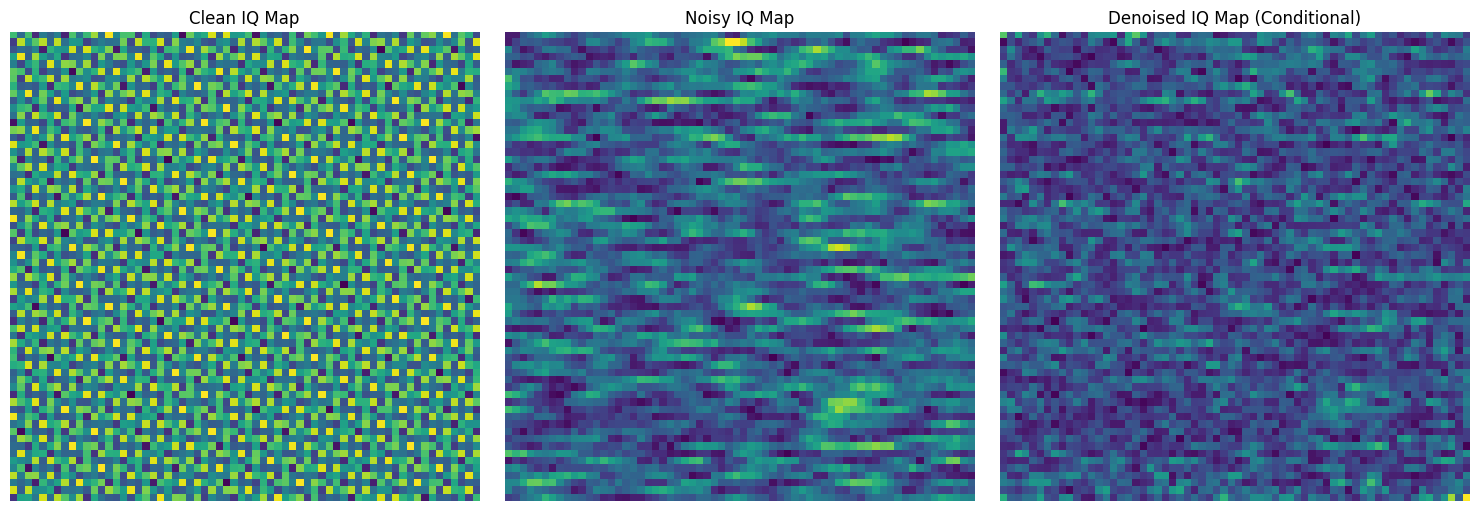

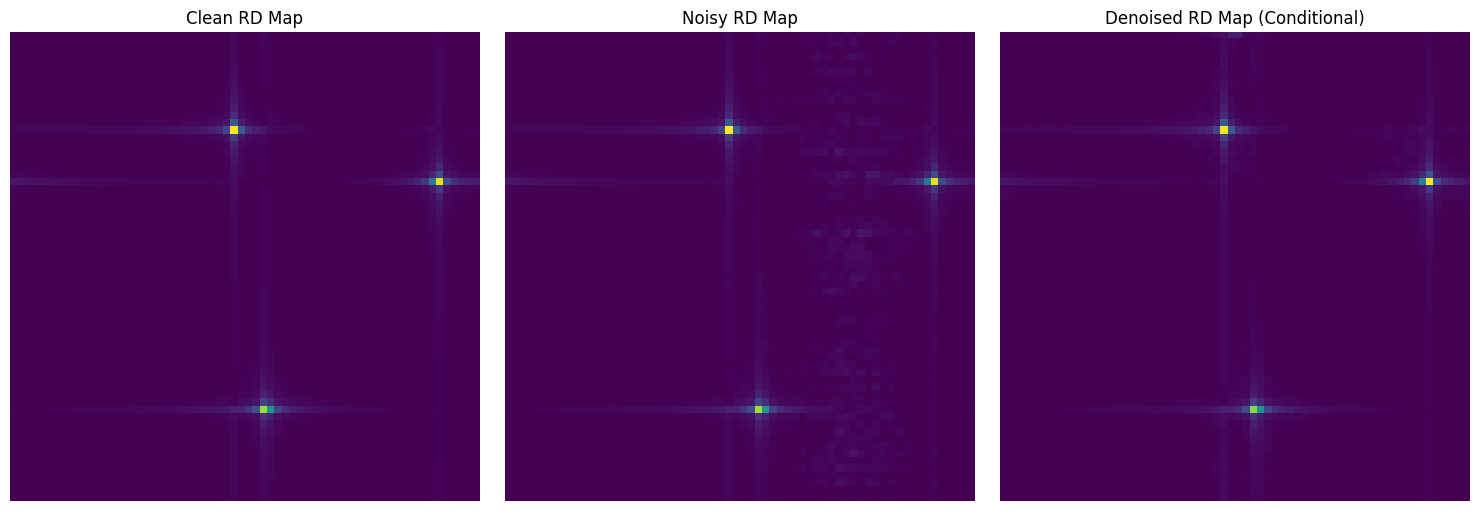

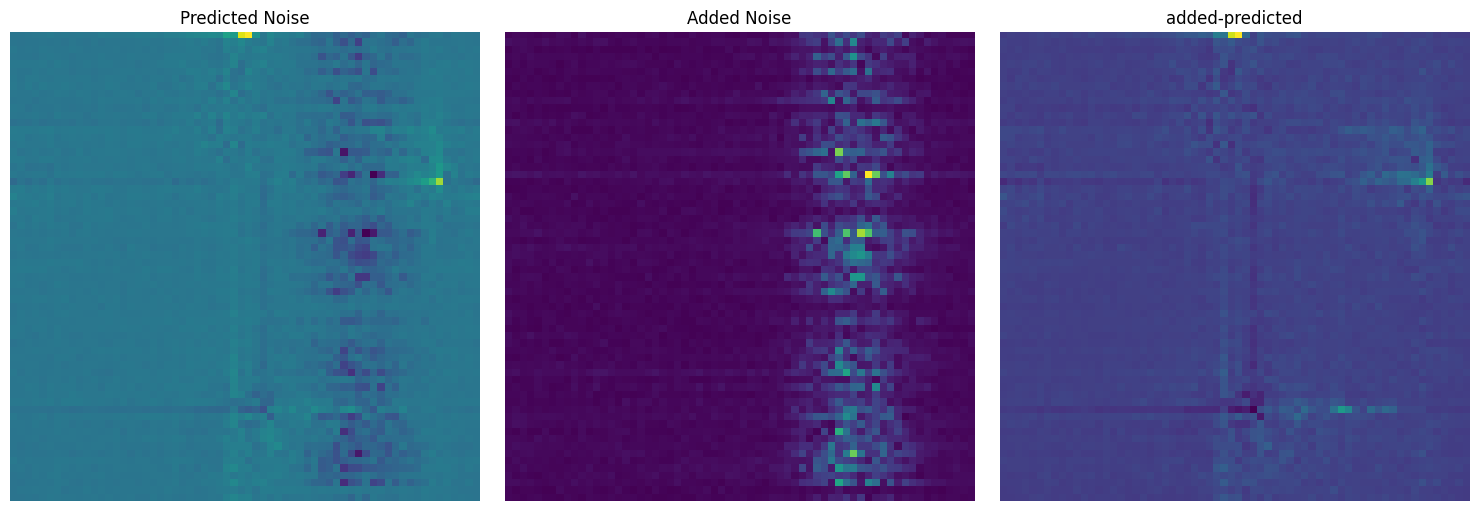

In [ ]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    # Ensure IQ_map is a tensor
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    # Convert IQ_map to a complex tensor if it's not already
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    # Get the device of the IQ_map
    dev = IQ_map.device
    
    # Generate steering matrices on the same device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    
    # Compute the RD map using the Hermitian transpose for R
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    
    # Move the result to CPU for visualization
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference():

    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
    cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # 2. Load the saved best checkpoint
    checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/notebooks/4ch_first_diffusion.pth"
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    # 3. Get a sample from dataset (or use your own custom input)
    #    Here we assume the dataset returns a tuple where:
    #       element 0: clean signal (complex tensor)
    #       element 3: IQ (noisy measurement, complex tensor)
    signal, C, W, IQ, _, _ = RadarDataset(num_samples=100, n_targets=8, random_n_targets=True,snr=30, cnr=15)[0]
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    
    # For visualization, use the original clean signal and IQ as complex images.
    # If they already are complex, no further conversion is needed.
    # (If needed, you can also combine two channels as done for generated_complex.)
    
    # 7. Visualization of RD maps
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(abs(signal), cmap='viridis')
    axes[0].set_title("Clean IQ Map")
    axes[0].axis("off")

    axes[1].imshow(abs(W+C), cmap='viridis')
    axes[1].set_title("Noisy IQ Map")
    axes[1].axis("off")

    axes[2].imshow(abs(IQ-generated_complex.cpu()), cmap='viridis')
    axes[2].set_title("Denoised IQ Map (Conditional)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(create_rd_map(signal), cmap='viridis')
    axes[0].set_title("Clean RD Map")
    axes[0].axis("off")

    axes[1].imshow(create_rd_map(IQ), cmap='viridis')
    axes[1].set_title("Noisy RD Map")
    axes[1].axis("off")

    axes[2].imshow(create_rd_map(generated_complex), cmap='viridis')
    axes[2].set_title("Denoised RD Map (Conditional)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(create_rd_map(generated_complex)-create_rd_map(IQ), cmap='viridis')
    axes[0].set_title("Predicted Noise")
    axes[0].axis("off")

    axes[1].imshow(create_rd_map(C)+create_rd_map(W), cmap='viridis')
    axes[1].set_title("Added Noise")
    axes[1].axis("off")

    axes[2].imshow(create_rd_map(C)+create_rd_map(W)-(create_rd_map(IQ)-create_rd_map(generated_complex)), cmap='viridis')
    axes[2].set_title("added-predicted")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

run_inference()


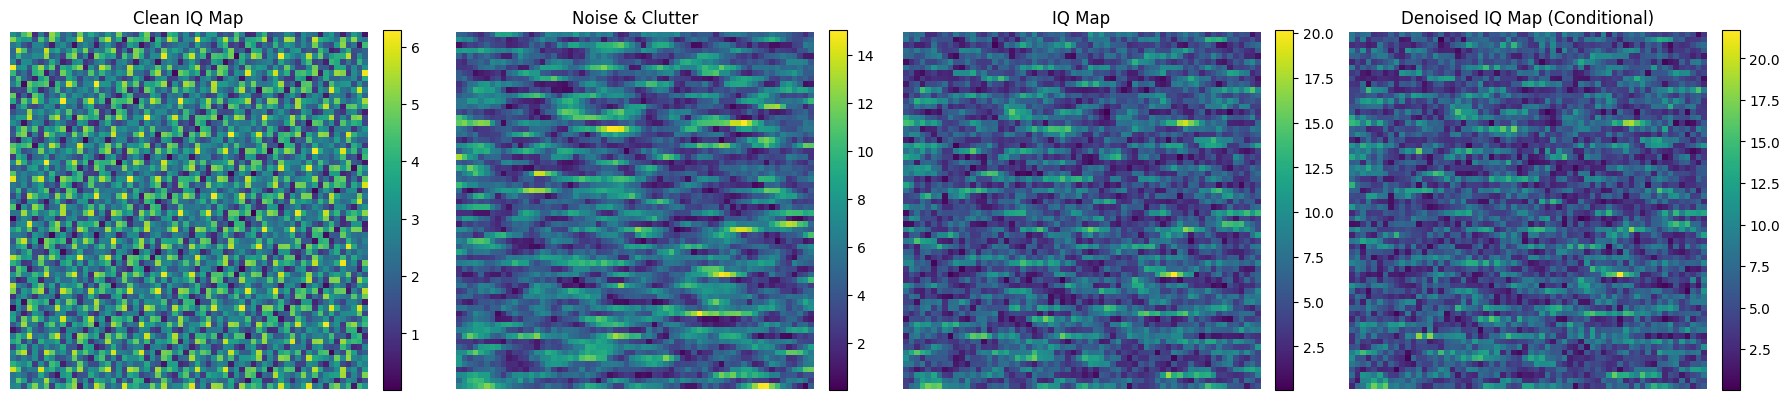

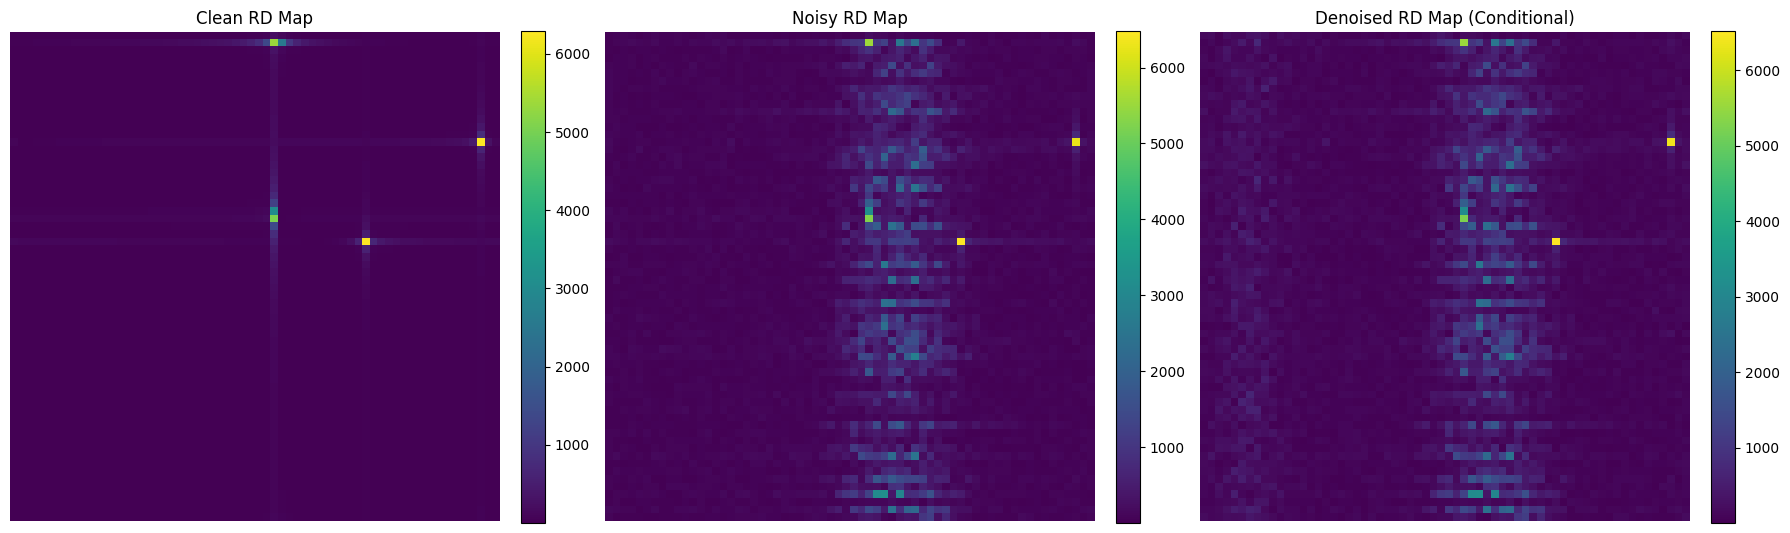

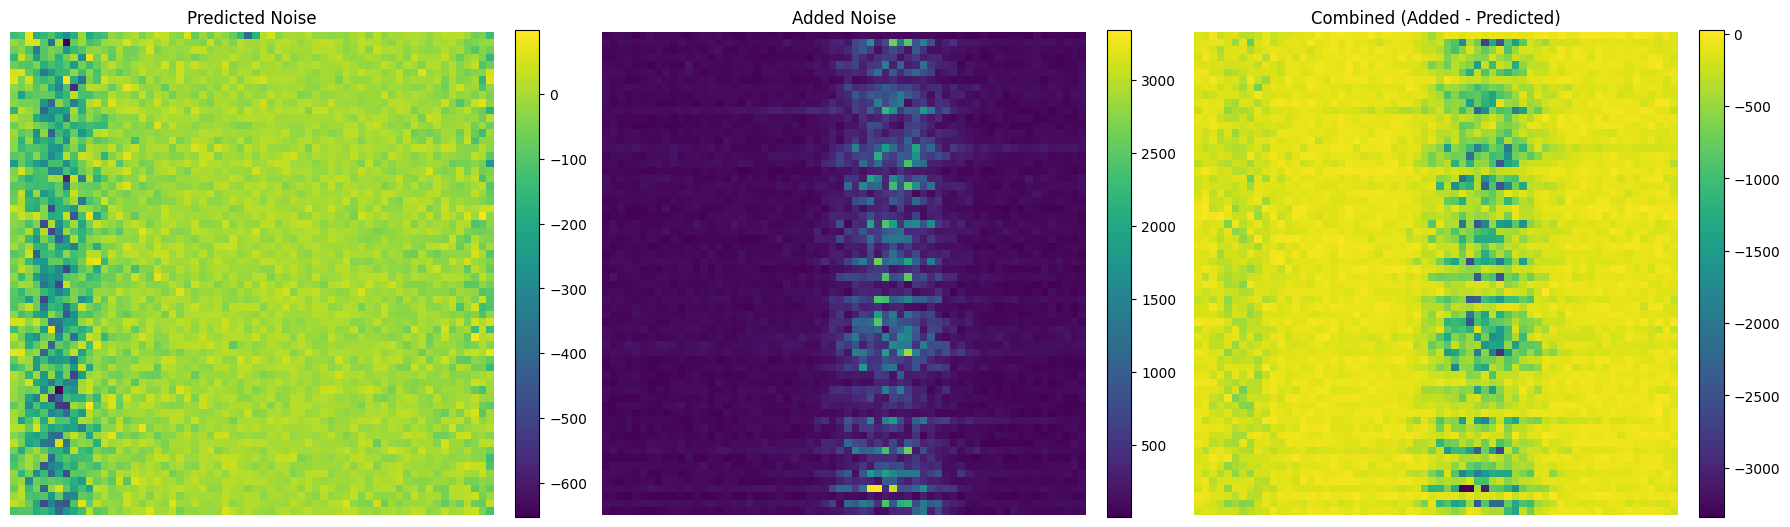

In [23]:
import torch
import matplotlib.pyplot as plt

def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    # Ensure IQ_map is a tensor
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    # Convert IQ_map to a complex tensor if it's not already
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    # Get the device of the IQ_map
    dev = IQ_map.device
    
    # Generate steering matrices on the same device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    
    # Compute the RD map using the Hermitian transpose for R
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    
    # Move the result to CPU for visualization
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference():
    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
    cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # 2. Load the saved best checkpoint
    checkpoint_path = "new_diffusion.pth"
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    # 3. Get a sample from dataset (or use your own custom input)
    #    Here we assume the dataset returns a tuple where:
    #       element 0: clean signal (complex tensor)
    #       element 3: IQ (noisy measurement, complex tensor)
    signal, C, W, IQ, _, _ = RadarDataset(num_samples=100, n_targets=8, random_n_targets=True, snr=10, cnr=15)[0]
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    
    # 7. Visualization of IQ maps
    fig, axes = plt.subplots(1,4, figsize=(18,6))
    
    im0 = axes[0].imshow(abs(signal), cmap='viridis')
    axes[0].set_title("Clean IQ Map")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(abs(W+C), cmap='viridis')
    axes[1].set_title("Noise & Clutter")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(abs(IQ), cmap='viridis')
    axes[2].set_title("IQ Map")
    axes[2].axis("off")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    im3 = axes[3].imshow(abs(generated_complex.cpu()), cmap='viridis')
    axes[3].set_title("Denoised IQ Map (Conditional)")
    axes[3].axis("off")
    plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
    

    plt.tight_layout()
    plt.show()




    # 8. Visualization of RD maps
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    
    rd_clean = create_rd_map(signal)
    rd_noisy = create_rd_map(IQ)
    rd_denoised = create_rd_map(generated_complex)
    
    im0 = axes[0].imshow(rd_clean, cmap='viridis')
    axes[0].set_title("Clean RD Map")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(rd_noisy, cmap='viridis')
    axes[1].set_title("Noisy RD Map")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(rd_denoised, cmap='viridis')
    axes[2].set_title("Denoised RD Map (Conditional)")
    axes[2].axis("off")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

    # 9. Visualization of Noise Differences
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    
    rd_pred_noise = create_rd_map(generated_complex) - create_rd_map(IQ)
    rd_added_noise = create_rd_map(C) + create_rd_map(W)
    rd_combined = create_rd_map(C) + create_rd_map(W) - (create_rd_map(IQ) - create_rd_map(generated_complex))
    
    im0 = axes[0].imshow(-rd_pred_noise, cmap='viridis')
    axes[0].set_title("Predicted Noise")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    im1 = axes[1].imshow(rd_added_noise, cmap='viridis')
    axes[1].set_title("Added Noise")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    im2 = axes[2].imshow(-rd_combined, cmap='viridis')
    axes[2].set_title("Combined (Added - Predicted)")
    axes[2].axis("off")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

run_inference()


## Gamma diffusion model

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Assume these helper modules are defined somewhere:
# SinusoidalPosEmb, DoubleConv, Down, Up, SelfAttention2d, RadarDataset

def sample_gamma_noise_like(x, shape_param=0.5):
    """
    Sample gamma noise with unit variance and zero mean.
    The gamma noise is generated from Gamma(k, theta) with:
       - variance = k * theta^2 = 1  => theta = sqrt(1/k)
       - mean = k * theta; we subtract this mean to center the noise.
    """
    theta = math.sqrt(1 / shape_param)
    gamma_dist = torch.distributions.Gamma(concentration=shape_param, rate=theta)
    noise = gamma_dist.sample(x.shape).to(x.device)
    noise = noise - shape_param * theta
    return noise

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=32):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        x1 = self.inc(x) 
        x2_skip, x2 = self.down1(x1)
        x3_skip, x3 = self.down2(x2) 
        x4_skip, x4 = self.down3(x3) 
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = sample_gamma_noise_like(x0)  # Use gamma noise here
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t.item()], device=x.device).float() / self.T).repeat(x.shape[0])
        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        # Use gamma noise in the reverse process, ensuring proper shape handling:
        noise = sample_gamma_noise_like(x) if t.item() > 0 else torch.zeros_like(x)
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        x = torch.randn(shape, device=cond.device)  # keep initial sample as Gaussian if desired
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x

def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)   
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

# Datasets and loaders (RadarDataset, random_split, etc. assumed to be defined)
full_dataset = RadarDataset(num_samples=100000, n_targets=8, random_n_targets=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)

# Model, diffusion process, and optimizer
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_psnrs = []
val_mses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "gamma_diffusion.pth")
        print("   --> Best model saved.")


Epoch 1/100: Train Loss = 0.2109 | Val Loss = 0.1822
   [Generation Metrics] MSE: 503453.3750 | PSNR: -22.15 dB
   --> Best model saved.
Epoch 2/100: Train Loss = 0.1545 | Val Loss = 0.1592
   [Generation Metrics] MSE: 513759.8125 | PSNR: -22.69 dB
   --> Best model saved.
Epoch 3/100: Train Loss = 0.1429 | Val Loss = 0.1514
   [Generation Metrics] MSE: 512246.1250 | PSNR: -19.76 dB
   --> Best model saved.


KeyboardInterrupt: 

## cross-attention

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Assume these helper modules are defined elsewhere:
# SinusoidalPosEmb, DoubleConv, Down, Up, SelfAttention2d, RadarDataset

class CrossAttention2d(nn.Module):
    """
    A simple cross-attention block for 2D feature maps.
    Query comes from the main feature map, while key and value come from the conditioning signal.
    """
    def __init__(self, in_channels, cond_channels, num_heads=4):
        super().__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        # For simplicity, we use 1x1 convolutions to project queries, keys, and values.
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv   = nn.Conv2d(cond_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(cond_channels, in_channels, kernel_size=1)
        self.out_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    
    def forward(self, x, cond):
        # x: (B, C, H, W) - main features
        # cond: (B, cond_channels, H, W) - conditioning features (after projection)
        B, C, H, W = x.shape

        q = self.query_conv(x)   # (B, C, H, W)
        k = self.key_conv(cond)  # (B, C, H, W)
        v = self.value_conv(cond)  # (B, C, H, W)

        # Reshape to (B, C, N) where N = H*W, then transpose to (B, N, C)
        q = q.view(B, C, -1).permute(0, 2, 1)  # (B, N, C)
        k = k.view(B, C, -1).permute(0, 2, 1)  # (B, N, C)
        v = v.view(B, C, -1).permute(0, 2, 1)  # (B, N, C)

        # Compute attention scores
        attn = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(C)  # (B, N, N)
        attn = F.softmax(attn, dim=-1)  # (B, N, N)
        out = torch.bmm(attn, v)  # (B, N, C)

        # Reshape back to (B, C, H, W) and project
        out = out.permute(0, 2, 1).contiguous().view(B, C, H, W)
        out = self.out_conv(out)
        # Residual connection
        return x + out

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, cond_channels=2, out_channels=1, time_emb_dim=32):
        """
        in_channels: number of channels for the noisy signal input
        cond_channels: number of channels for the conditioning signal (IQ)
        out_channels: output channels (e.g. denoised signal, here assumed 1 for simplicity)
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Initial convolutions on the noisy signal
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.bot   = DoubleConv(256, 512)
        self.attn  = SelfAttention2d(512)
        
        # Time projections for modulation at various scales
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)
        
        # Upsampling path
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64,  out_channels=64)
        
        # Final convolution to desired output channels
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Conditioning projections and cross attention blocks at multiple scales.
        # These project the raw cond (IQ, with cond_channels channels) to match the channel dimension.
        self.cond_proj_up1 = nn.Conv2d(cond_channels, 256, kernel_size=1)
        self.cross_attn_up1 = CrossAttention2d(256, 256)
        
        self.cond_proj_up2 = nn.Conv2d(cond_channels, 256, kernel_size=1)
        self.cross_attn_up2 = CrossAttention2d(256, 256)
        
        self.cond_proj_up3 = nn.Conv2d(cond_channels, 128, kernel_size=1)
        self.cross_attn_up3 = CrossAttention2d(128, 128)
        
        self.cond_proj_up4 = nn.Conv2d(cond_channels, 64, kernel_size=1)
        self.cross_attn_up4 = CrossAttention2d(64, 64)

    def forward(self, x, t, cond):
        """
        x: noisy signal input, shape (B, in_channels, H, W)
        t: time-step tensor (or normalized time embedding)
        cond: conditioning IQ signal, shape (B, cond_channels, H, W)
        """
        t_emb = self.time_emb(t)
        # Downsampling branch
        x1 = self.inc(x)
        x2_skip, x2 = self.down1(x1)
        x3_skip, x3 = self.down2(x2)
        x4_skip, x4 = self.down3(x3)
        # Bottleneck
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        # Upsampling branch with multi-level conditioning via cross attention
        
        # Level 1 (corresponding to x4_skip)
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        # Downsample cond to current resolution and project it
        cond1 = F.interpolate(cond, size=x.shape[-2:], mode='bilinear', align_corners=False)
        cond1_proj = self.cond_proj_up1(cond1)
        x = self.cross_attn_up1(x, cond1_proj)
        
        # Level 2 (corresponding to x3_skip)
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        cond2 = F.interpolate(cond, size=x.shape[-2:], mode='bilinear', align_corners=False)
        cond2_proj = self.cond_proj_up2(cond2)
        x = self.cross_attn_up2(x, cond2_proj)
        
        # Level 3 (corresponding to x2_skip)
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        cond3 = F.interpolate(cond, size=x.shape[-2:], mode='bilinear', align_corners=False)
        cond3_proj = self.cond_proj_up3(cond3)
        x = self.cross_attn_up3(x, cond3_proj)
        
        # Level 4 (corresponding to x1 skip)
        x = self.up4(x, x1)
        cond4 = F.interpolate(cond, size=x.shape[-2:], mode='bilinear', align_corners=False)
        cond4_proj = self.cond_proj_up4(cond4)
        x = self.cross_attn_up4(x, cond4_proj)
        
        output = self.outc(x)
        return output

class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        # Pass the noisy signal and condition separately
        noise_pred = self.model(x_noisy, t_norm, cond)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t.item()], device=x.device).float() / self.T).repeat(x.shape[0])
        noise_pred = self.model(x, t_norm, cond)
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise = torch.randn_like(x) if t.item() > 0 else torch.zeros_like(x)
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        # Initial sample is drawn from Gaussian noise
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x

def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        # Assume the signal is complex; here we treat real and imag separately for x0.
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            # For conditioning, we use IQ (assumed to have 2 channels)
            cond = torch.cat([IQ.real.unsqueeze(1), IQ.imag.unsqueeze(1)], dim=1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond = torch.cat([IQ.real, IQ.imag], dim=1)
        # For this example, we use only the magnitude (or one channel) for the noisy signal
        x0 = x0_real.to(device)
        cond = cond.to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond = torch.cat([IQ.real.unsqueeze(1), IQ.imag.unsqueeze(1)], dim=1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond = torch.cat([IQ.real, IQ.imag], dim=1)
        x0 = x0_real.to(device)
        cond = cond.to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val
    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

# Datasets and loaders (RadarDataset, random_split, etc. assumed to be defined)
full_dataset = RadarDataset(num_samples=100000, n_targets=8, random_n_targets=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True)
train_dataset_no_targets   = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)

# Instantiate model, diffusion process, and optimizer.
# Here, the noisy signal is assumed to have 1 channel, while cond (IQ) has 2 channels.
cond_unet = ConditionalUNet(in_channels=1, cond_channels=2, out_channels=1, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "cross_attention_diffusion.pth")
        print("   --> Best model saved.")


Epoch 1/100: Train Loss = 0.5860 | Val Loss = 0.5691
   [Generation Metrics] MSE: 1478.8152 | PSNR: 3.49 dB
   --> Best model saved.
Epoch 2/100: Train Loss = 0.4830 | Val Loss = 0.5021
   [Generation Metrics] MSE: 466.5571 | PSNR: 9.08 dB
   --> Best model saved.


KeyboardInterrupt: 

## Signal prediction (instead of noise)

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Assumed definitions for RadarDataset, DoubleConv, Down, Up, SelfAttention2d, SinusoidalPosEmb are available

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=32):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        x1 = self.inc(x)
        x2_skip, x2 = self.down1(x1)
        x3_skip, x3 = self.down2(x2)
        x4_skip, x4 = self.down3(x3)
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        # Generate a noisy version of x0 along with the noise used
        x_noisy, noise = self.q_sample(x0, t)
        # Normalize the timestep for conditioning
        t_norm = t.float() / self.T
        # Concatenate the noisy signal with the conditioning input
        model_input = torch.cat([x_noisy, cond], dim=1)
        # Predict the noise using the UNet
        noise_pred = self.model(model_input, t_norm)
        
        # Obtain scaling factors from the diffusion process
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        
        # Reconstruct x0 from the noisy signal and predicted noise
        x0_pred = (x_noisy - sqrt_one_minus_alpha_bar * noise_pred) / sqrt_alpha_bar
        
        # Use an MSE loss directly between the reconstructed x0 and the true x0
        return F.mse_loss(x0_pred, x0)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])
        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x

def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

full_dataset = RadarDataset(num_samples=100000, n_targets=8, random_n_targets=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Combining datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)

# Model, diffusion, and optimizer setup
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)

num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "signal_pred_diffusion.pth")
        print("   --> Best model saved.")


Epoch 1/100: Train Loss = 484.4336 | Val Loss = 230.3992
   [Generation Metrics] MSE: 307.0282 | PSNR: 11.61 dB
   --> Best model saved.
Epoch 2/100: Train Loss = 146.1934 | Val Loss = 106.4220
   [Generation Metrics] MSE: 199.8817 | PSNR: 12.27 dB
   --> Best model saved.
Epoch 3/100: Train Loss = 79.0735 | Val Loss = 68.3922
   [Generation Metrics] MSE: 221.4178 | PSNR: 14.27 dB
   --> Best model saved.
Epoch 4/100: Train Loss = 53.3010 | Val Loss = 43.5015
   [Generation Metrics] MSE: 157.6184 | PSNR: 15.36 dB
   --> Best model saved.
Epoch 5/100: Train Loss = 34.7684 | Val Loss = 30.4548
   [Generation Metrics] MSE: 112.7883 | PSNR: 17.00 dB
   --> Best model saved.
Epoch 6/100: Train Loss = 26.0039 | Val Loss = 23.7445
   [Generation Metrics] MSE: 89.7295 | PSNR: 17.38 dB
   --> Best model saved.
Epoch 7/100: Train Loss = 20.4608 | Val Loss = 19.7967
   [Generation Metrics] MSE: 102.5644 | PSNR: 17.67 dB
   --> Best model saved.
Epoch 8/100: Train Loss = 16.8014 | Val Loss = 16.43

KeyboardInterrupt: 

## FOR CHATS

In [ ]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=32):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        x1 = self.inc(x) 
        x2_skip, x2 = self.down1(x1)
        x3_skip, x3 = self.down2(x2) 
        x4_skip, x4 = self.down3(x3) 
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # instance of ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])
        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x

def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)   
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr
full_dataset = RadarDataset(num_samples=100000, n_targets=8, random_n_targets=True)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_psnrs = []
val_mses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "best_cond_diffusion.pth")
        print("   --> Best model saved.")

In [ ]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None
        self.N = 64  
        self.K = 64   
        self.B = 50e6  
        self.T0 = 1e-3  
        self.fc = 9.39e9 
        self.c = 3e8 
        self.CNR = 15  
        self.r_min, self.r_max = 0, 189  
        self.v_min, self.v_max = -7.8, 7.8  
        self.vc_min, self.vc_max = -7.8, 7.8 
        self.dr = 3       
        self.dv = 0.249   
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases) 

        if (self.snr_dB is None) or (self.cnr_dB is None):
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                S_raw = []
                for i in range(n):
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  
                    )
                    S_raw.append(s_i)
                S_unscaled = sum(S_raw)

            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled 
            final_noise_power = W.abs().pow(2).mean()
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)
        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled
        X = S + C + W
        
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)
        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB

## Older functions used with RD

In [ ]:
# class ConditionalUNet(nn.Module):
#     def __init__(self, in_channels=2, out_channels=1, time_emb_dim=32):
#         """
#         in_channels=2 because we concatenate:
#             - x_t: the noised (or current reverse process) image (1 channel)
#             - cond: the conditioning (noisy observed) image (1 channel)
#         """
#         super().__init__()
#         self.time_emb = nn.Sequential(
#             SinusoidalPosEmb(time_emb_dim),
#             nn.Linear(time_emb_dim, time_emb_dim),
#             nn.SiLU()
#         )
#         # Encoder
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 256)
#         # Bottleneck with attention
#         self.bot = DoubleConv(256, 512)
#         self.attn = SelfAttention2d(512)
#         # Decoder with time embedding injections
#         self.up1 = Up(512, skip_channels=256, out_channels=256)
#         self.up2 = Up(256, skip_channels=256, out_channels=256)
#         self.up3 = Up(256, skip_channels=128, out_channels=128)
#         self.up4 = Up(128, skip_channels=64, out_channels=64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         # Time embeddings injected at various stages:
#         self.time_proj_bot = nn.Linear(time_emb_dim, 512)
#         self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
#         self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
#         self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

#     def forward(self, x, t):
#         """
#         x: (B,2,H,W) where channels are [x_t, cond]
#         t: (B,) normalized timesteps
#         """
#         t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

#         x1 = self.inc(x)                 # (B,64,H,W)
#         x2_skip, x2 = self.down1(x1)     # (B,128,...)
#         x3_skip, x3 = self.down2(x2)     # (B,256,...)
#         x4_skip, x4 = self.down3(x3)     # (B,256,...)
        
#         x_bot = self.bot(x4)
#         x_bot = self.attn(x_bot)
#         t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
#         x_bot = x_bot + t_bot
        
#         x = self.up1(x_bot, x4_skip)
#         t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
#         x = x + t_up1
        
#         x = self.up2(x, x3_skip)
#         t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
#         x = x + t_up2
        
#         x = self.up3(x, x2_skip)
#         t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
#         x = x + t_up3
        
#         x = self.up4(x, x1)
#         output = self.outc(x)
#         return output

In [ ]:
# class ConditionalDiffusion(nn.Module):
#     def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
#         super().__init__()
#         self.model = model  # ConditionalUNet
#         self.T = T
#         self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
#         self.register_buffer("alphas", 1.0 - self.betas)
#         self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

#     def q_sample(self, x0, t, noise=None):
#         """
#         Forward diffusion: add noise to x0 at timestep t.
#         """
#         if noise is None:
#             noise = torch.randn_like(x0)
#         sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
#         sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
#         return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

#     def p_losses(self, x0, t, cond):
#         """
#         Loss: train network to predict the noise added.
#         x0: clean image (B,1,H,W)
#         cond: conditioning (observed noisy image) (B,1,H,W)
#         """
#         x_noisy, noise = self.q_sample(x0, t)
#         t_norm = t.float() / self.T
        
#         # Concatenate along channel dimension: [x_noisy, cond]
#         model_input = torch.cat([x_noisy, cond], dim=1)
#         noise_pred = self.model(model_input, t_norm)
#         return F.mse_loss(noise_pred, noise)

#     @torch.no_grad()
#     def p_sample(self, x, t, cond):
#         """
#         One reverse diffusion step (from x_t to x_{t-1}).
#         """
#         betas_t = self.betas[t].view(-1, 1, 1, 1)
#         alphas_t = self.alphas[t].view(-1, 1, 1, 1)
#         alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
#         t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

#         model_input = torch.cat([x, cond], dim=1)
#         noise_pred = self.model(model_input, t_norm)

#         coef1 = 1 / torch.sqrt(alphas_t)
#         coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
#         mean = coef1 * (x - coef2 * noise_pred)
        
#         noise = torch.randn_like(x) if t > 0 else 0
#         return mean + torch.sqrt(betas_t) * noise

#     @torch.no_grad()
#     def sample(self, cond, shape):
#         """
#         Generate a denoised image conditioned on cond.
#         cond: (B,1,H,W) the observed noisy image.
#         shape: desired shape of x (B,1,H,W)
#         """
#         x = torch.randn(shape, device=cond.device)
#         for t in reversed(range(self.T)):
#             t_tensor = torch.tensor([t], device=x.device)
#             x = self.p_sample(x, t_tensor, cond)
#         return x


In [ ]:
# def train_one_epoch(diffusion, dataloader, optimizer, device, kind):
#     diffusion.train()
#     epoch_loss = 0
#     for i, batch in enumerate(dataloader):
#         # Unpack the tuple from the new dataset.
#         signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
#         # "clean" is the signal, and "noisy" is the IQ data.
#         if kind==0:
#             x0 = signal.real.to(device)   # clean signal
#             cond = IQ.real.to(device)     # noisy IQ
#         else:
#             x0 = signal.imag.to(device)   # clean signal
#             cond = IQ.imag.to(device)     # noisy IQ
#         # Ensure the inputs have a channel dimension (if not already present).
#         if x0.ndim == 3:
#             x0 = x0.unsqueeze(1)
#         if cond.ndim == 3:
#             cond = cond.unsqueeze(1)
        
#         # Sample random timesteps for diffusion.
#         t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        
#         # Compute loss.
#         loss = diffusion.p_losses(x0, t, cond)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
        
#     return epoch_loss / len(dataloader)


# @torch.no_grad()
# def validate(diffusion, dataloader, device, kind):
#     diffusion.eval()
#     val_loss = 0
#     gen_mse, gen_psnr = None, None

#     for i, batch in enumerate(dataloader):
#         signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
#         if kind == 0:
#             x0 = signal.real.to(device)   # clean signal
#             cond = IQ.real.to(device)     # noisy IQ        
#         else:
#             x0 = signal.imag.to(device)   # clean signal
#             cond = IQ.imag.to(device)     # noisy IQ
#         if x0.ndim == 3:
#             x0 = x0.unsqueeze(1)
#         if cond.ndim == 3:
#             cond = cond.unsqueeze(1)
        
#         t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
#         loss = diffusion.p_losses(x0, t, cond)
#         val_loss += loss.item()

#         # For the first batch, generate a sample and compute metrics.
#         if i == 0:
#             generated = diffusion.sample(cond, x0.shape)
#             mse_val = F.mse_loss(generated, x0).item()
#             psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
#             gen_mse, gen_psnr = mse_val, psnr_val

#     avg_val_loss = val_loss / len(dataloader)
#     return avg_val_loss, gen_mse, gen_psnr
